In [1]:
# !pip install -U sentence-transformers scikit-learn umap-learn

In [2]:
# !pip install pandas numpy nltk spacy pymorphy3
# python -m spacy download ru_core_news_sm  # для русского
# python -m spacy download en_core_web_sm   # для английского

In [ ]:
# !python -m spacy download en_core_web_sm   # для английского

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import DBSCAN
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
# df = pd.read_csv('/content/Reviews.csv', encoding='utf-8', engine='python')
# df

In [ ]:
# df = df[0:200_000]
# print(df.shape)

In [ ]:
# del df['Id']
# del df['ProductId']
# del df['UserId']
# df = df.dropna().reset_index(drop=True)
# df

In [ ]:
# import pandas as pd
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import pymorphy3
# from collections import Counter
# import spacy
# from tqdm import tqdm  # Добавляем импорт tqdm

# # Загрузка стоп-слов
# nltk.download('stopwords')
# nltk.download('punkt')

# # Добавляем для красивого отображения прогресса в pandas
# tqdm.pandas()

# class TextPreprocessor:
#     def __init__(self, language='eng', min_word_freq=5):
#         self.language = language
#         self.min_word_freq = min_word_freq
#         self.stop_words = set(stopwords.words(language))

#         self.spacy_nlp = spacy.load("en_core_web_sm")
#         self.frequent_words = set()

#     def identify_frequent_words(self, texts):
#         """Определение слишком частых слов"""
#         all_words = []
#         print("Сбор слов для анализа частотности...")
#         for text in tqdm(texts, desc="Анализ частотности слов"):
#             if pd.notna(text):
#                 words = re.findall(r'\b\w+\b', text.lower())
#                 all_words.extend(words)

#         word_counts = Counter(all_words)
#         self.frequent_words = {word for word, count in word_counts.items()
#                               if count >= self.min_word_freq}
#         return self.frequent_words

#     def clean_text(self, text):
#         """Основная функция очистки текста"""
#         if pd.isna(text):
#             return ""

#         # Приведение к нижнему регистру
#         text = text.lower()

#         # Удаление специальных символов и цифр
#         text = re.sub(r'[^а-яa-zё\s]', ' ', text)  # для русского + английского
#         text = re.sub(r'\d+', ' ', text)
#         text = re.sub(r'\s+', ' ', text).strip()

#         return text

#     def lemmatize_text(self, text):
#         """Лемматизация текста"""
#         if not text:
#             return ""

#         # Для английского используем spacy
#         doc = self.spacy_nlp(text)
#         lemmas = [token.lemma_ for token in doc
#                   if not token.is_stop and token.text not in self.frequent_words]
#         return ' '.join(lemmas)

#     def preprocess_dataframe(self, df, text_column):
#         """Полная предобработка датафрейма"""

#         # Копируем датафрейм
#         df_processed = df.copy()

#         # Определяем частые слова
#         print("Определение частых слов...")
#         texts = df_processed[text_column].dropna().tolist()
#         frequent_words = self.identify_frequent_words(texts)
#         print(f"Найдено {len(frequent_words)} частых слов")

#         # Очистка текста
#         print("Очистка текста...")
#         df_processed['cleaned_text'] = df_processed[text_column].progress_apply(self.clean_text)

#         # Лемматизация
#         print("Лемматизация...")
#         df_processed['lemmatized_text'] = df_processed['cleaned_text'].progress_apply(self.lemmatize_text)

#         # Удаление пустых текстов после обработки
#         df_processed = df_processed[df_processed['lemmatized_text'].str.len() > 0]

#         return df_processed

# # Инициализация препроцессора
# preprocessor = TextPreprocessor(language='english', min_word_freq=2)

# # Обработка данных
# df_processed = preprocessor.preprocess_dataframe(df, 'Text')

# print("Исходные данные:")
# print(df)
# print("\nОбработанные данные:")
# print(df_processed[['Text', 'lemmatized_text']])

In [ ]:
# df_processed.to_csv('processed_text.csv')

In [4]:
df_processed = pd.read_csv('processed_text.csv')

In [5]:
def subtract_one(x):
    try:
        return float(x) - 1
    except (ValueError, TypeError):
        return x  # оставляем как есть, если не число

df_processed['Score'] = df_processed['Score'].apply(subtract_one)

In [6]:
# def subtract_one(x):
#     try:
#         return float(x) - 1
#     except (ValueError, TypeError):
#         return x  # оставляем как есть, если не число

# df['Score'] = df['Score'].apply(subtract_one)

Кластеризация комментариев

In [7]:
df= df_processed.copy()

In [8]:
df.Score.unique()

array([4., 3., 2., 0., 1.])

In [9]:
df.to_csv('df_to_work.csv')

In [10]:
df.Score.unique()

array([4., 3., 2., 0., 1.])

In [11]:
df.Score.value_counts()

,count
Score,
4.0,8093
3.0,2030
0.0,1437
2.0,1188
1.0,748


# BERT

In [12]:
pip install transformers torch pandas numpy scikit-learn matplotlib seaborn

In [13]:
# device = torch.device('cpu')  # Временно используйте CPU
# model = model.to(device)

In [14]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from torch.optim import AdamW

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# class BERTClassifier:
#     def __init__(self, num_classes=5, model_name='bert-base-uncased', df=None):
#         self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#         print(f"Using device: {self.device}")

#         self.tokenizer = BertTokenizer.from_pretrained(model_name)
#         self.model = BertForSequenceClassification.from_pretrained(
#             model_name,
#             num_labels=num_classes
#         )
#         self.model.resize_token_embeddings(len(self.tokenizer))


#         self.class_weights = None
#         if df is not None:
#             self.class_weights = self._compute_class_weights(df)
#             print(f"Class weights: {self.class_weights}")

#         print('model ready')
#         self.model = self.model.to(self.device)
#         print('device done')
#         self.num_classes = num_classes
#         print('classes', self.num_classes)

#     def _compute_class_weights(self, df, label_column='Score'):
#         """Вычисление весов классов для балансировки"""
#         from sklearn.utils.class_weight import compute_class_weight
#         import numpy as np

#         labels = df[label_column].values
#         class_weights = compute_class_weight(
#             'balanced',
#             classes=np.unique(labels),
#             y=labels
#         )
#         return torch.tensor(class_weights, dtype=torch.float).to(self.device)


#     def prepare_data(self, df, text_column='Text', label_column='Score'):
#         """Подготовка данных для обучения с учетом устройств"""
#         texts = df[text_column].values
#         labels = df[label_column].values
#         print('LABELS', labels)

#         train_texts, val_texts, train_labels, val_labels = train_test_split(
#             texts, labels, test_size=0.2, random_state=42, stratify=labels
#         )

#         print(f"Training samples: {len(train_texts)}")
#         print(f"Validation samples: {len(val_texts)}")

#         train_dataset = ReviewDataset(train_texts, train_labels, self.tokenizer)
#         val_dataset = ReviewDataset(val_texts, val_labels, self.tokenizer)

#         batch_size = 32
#         train_loader = DataLoader(
#             train_dataset,
#             batch_size=batch_size,
#             shuffle=True,
#             pin_memory=True,
#             num_workers=2
#         )
#         val_loader = DataLoader(
#             val_dataset,
#             batch_size=batch_size,
#             shuffle=False,
#             pin_memory=True,
#             num_workers=2
#         )

#         return train_loader, val_loader

#     def train(self, train_loader, val_loader, epochs=100, learning_rate=2e-5):
#         """Обучение модели с учетом дисбаланса"""
#         print(f"Model device: {next(self.model.parameters()).device}")
#         print(f"Target device: {self.device}")

#         optimizer = AdamW(self.model.parameters(), lr=learning_rate)
#         total_steps = len(train_loader) * epochs

#         if self.class_weights is not None:
#             criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
#             print("Using weighted CrossEntropyLoss")
#         else:
#             criterion = torch.nn.CrossEntropyLoss()
#             print("Using standard CrossEntropyLoss")

#         scheduler = get_linear_schedule_with_warmup(
#             optimizer,
#             num_warmup_steps=0,
#             num_training_steps=total_steps
#         )

#         best_accuracy = 0
#         training_stats = []

#         for epoch in range(epochs):
#             print(f'Epoch {epoch + 1}/{epochs}')
#             print('-' * 50)

#             self.model.train()
#             total_train_loss = 0
#             train_preds = []
#             train_true = []

#             for batch in tqdm(train_loader, desc='Training'):
#                 input_ids = batch['input_ids'].to(self.device)
#                 attention_mask = batch['attention_mask'].to(self.device)
#                 labels = batch['labels'].to(self.device)

#                 self.model.zero_grad()

#                 outputs = self.model(
#                     input_ids=input_ids,
#                     attention_mask=attention_mask,
#                     labels=labels
#                 )

#                 logits = outputs.logits
#                 loss = criterion(logits, labels)
#                 total_train_loss += loss.item()

#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
#                 optimizer.step()
#                 scheduler.step()


#                 preds = torch.argmax(logits, dim=1)
#                 train_preds.extend(preds.cpu().numpy())
#                 train_true.extend(labels.cpu().numpy())

#             avg_train_loss = total_train_loss / len(train_loader)
#             train_accuracy = accuracy_score(train_true, train_preds)

#             val_accuracy, avg_val_loss = self.evaluate(val_loader)


#             training_stats.append({
#                 'epoch': epoch + 1,
#                 'train_loss': avg_train_loss,
#                 'train_accuracy': train_accuracy,
#                 'val_loss': avg_val_loss,
#                 'val_accuracy': val_accuracy
#             })

#             print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
#             print(f'Val loss: {avg_val_loss:.4f}, Val accuracy: {val_accuracy:.4f}')

#             if val_accuracy > best_accuracy:
#                 best_accuracy = val_accuracy
#                 torch.save(self.model.state_dict(), 'best_bert_model.pth')
#                 print('New best model saved!')

#             print()

#         return training_stats


#     def evaluate(self, val_loader):
#         """Валидация модели"""
#         self.model.eval()
#         total_val_loss = 0
#         val_preds = []
#         val_true = []
#         if self.class_weights is not None:
#             criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
#         else:
#             criterion = torch.nn.CrossEntropyLoss()

#         with torch.no_grad():
#             for batch in tqdm(val_loader, desc='Validation'):
#                 input_ids = batch['input_ids'].to(self.device)
#                 attention_mask = batch['attention_mask'].to(self.device)
#                 labels = batch['labels'].to(self.device)

#                 outputs = self.model(
#                     input_ids=input_ids,
#                     attention_mask=attention_mask,
#                     labels=labels
#                 )


#                 logits = outputs.logits
#                 loss = criterion(logits, labels)
#                 total_val_loss += loss.item()

#                 preds = torch.argmax(logits, dim=1)
#                 val_preds.extend(preds.cpu().numpy())
#                 val_true.extend(labels.cpu().numpy())

#         avg_val_loss = total_val_loss / len(val_loader)
#         val_accuracy = accuracy_score(val_true, val_preds)

#         return val_accuracy, avg_val_loss

#     def predict(self, texts):
#         """Предсказание для новых текстов"""
#         self.model.eval()
#         predictions = []
#         probabilities = []

#         with torch.no_grad():
#             for text in texts:
#                 encoding = self.tokenizer.encode_plus(
#                     text,
#                     add_special_tokens=True,
#                     max_length=128,
#                     padding='max_length',
#                     truncation=True,
#                     return_attention_mask=True,
#                     return_tensors='pt',
#                 )

#                 input_ids = encoding['input_ids'].to(self.device)
#                 attention_mask = encoding['attention_mask'].to(self.device)

#                 outputs = self.model(
#                     input_ids=input_ids,
#                     attention_mask=attention_mask
#                 )

#                 logits = outputs.logits
#                 probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
#                 pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

#                 predictions.append(pred)
#                 probabilities.append(probs)

#         return predictions, probabilities


In [ ]:


# def plot_training_stats(stats):
#     """Визуализация процесса обучения"""
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#     # Loss
#     epochs = [s['epoch'] for s in stats]
#     train_loss = [s['train_loss'] for s in stats]
#     val_loss = [s['val_loss'] for s in stats]

#     ax1.plot(epochs, train_loss, 'b-', label='Training loss')
#     ax1.plot(epochs, val_loss, 'r-', label='Validation loss')
#     ax1.set_title('Training and Validation Loss')
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Loss')
#     ax1.legend()

#     # Accuracy
#     train_acc = [s['train_accuracy'] for s in stats]
#     val_acc = [s['val_accuracy'] for s in stats]

#     ax2.plot(epochs, train_acc, 'b-', label='Training accuracy')
#     ax2.plot(epochs, val_acc, 'r-', label='Validation accuracy')
#     ax2.set_title('Training and Validation Accuracy')
#     ax2.set_xlabel('Epochs')
#     ax2.set_ylabel('Accuracy')
#     ax2.legend()

#     plt.tight_layout()
#     plt.savefig('training_stats.png')
#     plt.show()


# def main():

#     df = pd.read_csv('df_to_work.csv')

#     print("Data sample:")
#     print(df.head())
#     print(f"\nTotal samples: {len(df)}")
#     print(f"Number of clusters: {df['Score'].nunique()}")

#     print("Initializing BERT classifier...")
#     classifier = BERTClassifier(num_classes=len(df['Score'].unique()), df=df)


#     print("Preparing data...")
#     train_loader, val_loader = classifier.prepare_data(df)

#     print("Training model...")
#     training_stats = classifier.train(train_loader, val_loader, epochs=35)

#     plot_training_stats(training_stats)


# if __name__ == "__main__":
#     main()

In [ ]:
# df_balanced.cluster.value_counts()

In [ ]:
# from collections import Counter
# import re

# def get_cluster_keywords(texts, clusters, n_keywords=10):
#     cluster_keywords = {}
#     for cluster_id in set(clusters):
#         cluster_texts = [text for text, cl in zip(texts, clusters) if cl == cluster_id]
#         all_words = ' '.join(cluster_texts).lower()
#         words = re.findall(r'\w+', all_words)
#         word_counts = Counter(words)
#         cluster_keywords[cluster_id] = word_counts.most_common(n_keywords)
#     return cluster_keywords

# keywords = get_cluster_keywords(df.lemmatized_text, df.Score)
# for cluster_id, words in keywords.items():
#     print(f"Кластер {cluster_id}: {[word for word, count in words]}")

In [ ]:
# df[['lemmatized_text', 'cluster']].to_excel('dd.xlsx')

С обработкой

In [15]:

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class BERTClassifier:
    def __init__(self, num_classes=5, model_name='bert-base-uncased', df=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_classes
        )
        self.model.resize_token_embeddings(len(self.tokenizer))


        self.class_weights = None
        if df is not None:
            self.class_weights = self._compute_class_weights(df)
            print(f"Class weights: {self.class_weights}")

        print('model ready')
        self.model = self.model.to(self.device)
        print('device done')
        self.num_classes = num_classes
        print('classes', self.num_classes)

    def _compute_class_weights(self, df, label_column='Score'):
        """Вычисление весов классов для балансировки"""
        from sklearn.utils.class_weight import compute_class_weight
        import numpy as np

        labels = df[label_column].values
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(labels),
            y=labels
        )
        return torch.tensor(class_weights, dtype=torch.float).to(self.device)


    def prepare_data(self, df, text_column='lemmatized_text', label_column='Score'):
        """Подготовка данных для обучения с учетом устройств"""
        texts = df[text_column].values
        labels = df[label_column].values
        print('LABELS', labels)

        train_texts, val_texts, train_labels, val_labels = train_test_split(
            texts, labels, test_size=0.2, random_state=42, stratify=labels
        )

        print(f"Training samples: {len(train_texts)}")
        print(f"Validation samples: {len(val_texts)}")

        train_dataset = ReviewDataset(train_texts, train_labels, self.tokenizer)
        val_dataset = ReviewDataset(val_texts, val_labels, self.tokenizer)

        batch_size = 64
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=2
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            pin_memory=True,
            num_workers=2
        )

        return train_loader, val_loader

    def train(self, train_loader, val_loader, epochs=100, learning_rate=2e-5):
        """Обучение модели с учетом дисбаланса"""
        print(f"Model device: {next(self.model.parameters()).device}")
        print(f"Target device: {self.device}")

        optimizer = AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * epochs

        if self.class_weights is not None:
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            print("Using weighted CrossEntropyLoss")
        else:
            criterion = torch.nn.CrossEntropyLoss()
            print("Using standard CrossEntropyLoss")

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        best_accuracy = 0
        training_stats = []

        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            print('-' * 50)

            self.model.train()
            total_train_loss = 0
            train_preds = []
            train_true = []

            for batch in tqdm(train_loader, desc='Training'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                self.model.zero_grad()

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                logits = outputs.logits
                loss = criterion(logits, labels)
                total_train_loss += loss.item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()


                preds = torch.argmax(logits, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_true.extend(labels.cpu().numpy())

            avg_train_loss = total_train_loss / len(train_loader)
            train_accuracy = accuracy_score(train_true, train_preds)

            val_accuracy, avg_val_loss = self.evaluate(val_loader)


            training_stats.append({
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'train_accuracy': train_accuracy,
                'val_loss': avg_val_loss,
                'val_accuracy': val_accuracy
            })

            print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
            print(f'Val loss: {avg_val_loss:.4f}, Val accuracy: {val_accuracy:.4f}')

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(self.model.state_dict(), 'best_bert_model.pth')
                print('New best model saved!')

            print()

        return training_stats


    def evaluate(self, val_loader):
        """Валидация модели"""
        self.model.eval()
        total_val_loss = 0
        val_preds = []
        val_true = []
        if self.class_weights is not None:
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            criterion = torch.nn.CrossEntropyLoss()

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )


                logits = outputs.logits
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true, val_preds)

        return val_accuracy, avg_val_loss

    def predict(self, texts):
        """Предсказание для новых текстов"""
        self.model.eval()
        predictions = []
        probabilities = []

        with torch.no_grad():
            for text in texts:
                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=128,
                    padding='max_length',
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors='pt',
                )

                input_ids = encoding['input_ids'].to(self.device)
                attention_mask = encoding['attention_mask'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                logits = outputs.logits
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

                predictions.append(pred)
                probabilities.append(probs)

        return predictions, probabilities


Data sample:
   Unnamed: 0.1  Unnamed: 0                   ProfileName  \
0             0          18                       Wolfee1   
1             1          21                Tammy Anderson   
2             2          25  Deborah S. Linzer "Cat Lady"   
3             3          30                       Sherril   
4             4          31       Molly V. Smith "staral"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0    4.0  1324598400   
1                     0                       0    4.0  1308960000   
2                     0                       0    4.0  1288310400   
3                     0                       0    4.0  1297641600   
4                     0                       1    4.0  1288310400   

                  Summary                                               Text  \
0      GREAT SWEET CANDY!  Twizzlers, Strawberry my childhood favorite ca...   
1               TWIZZLERS  I bought the

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: tensor([1.8784, 3.6086, 2.2721, 1.3297, 0.3335], device='cuda:0')
model ready
device done
classes 5
Preparing data...
LABELS [4. 4. 4. ... 4. 4. 0.]
Training samples: 10796
Validation samples: 2700
Training model...
Model device: cuda:0
Target device: cuda
Using weighted CrossEntropyLoss
Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 1.6161, Train accuracy: 0.2157
Val loss: 1.6099, Val accuracy: 0.1830
New best model saved!

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 1.6086, Train accuracy: 0.2230
Val loss: 1.5999, Val accuracy: 0.3652
New best model saved!

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 1.5897, Train accuracy: 0.2800
Val loss: 1.5931, Val accuracy: 0.3326

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 1.5053, Train accuracy: 0.3436
Val loss: 1.6429, Val accuracy: 0.2715

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 1.3314, Train accuracy: 0.4001
Val loss: 1.8079, Val accuracy: 0.3122

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 1.0842, Train accuracy: 0.4742
Val loss: 2.0224, Val accuracy: 0.2241

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.8715, Train accuracy: 0.5366
Val loss: 2.2378, Val accuracy: 0.2848

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.6778, Train accuracy: 0.6072
Val loss: 2.5275, Val accuracy: 0.2989

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.5479, Train accuracy: 0.6610
Val loss: 2.7335, Val accuracy: 0.3111

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.4310, Train accuracy: 0.7221
Val loss: 3.0594, Val accuracy: 0.3315

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.3575, Train accuracy: 0.7682
Val loss: 3.2892, Val accuracy: 0.4281
New best model saved!

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.33it/s]


Train loss: 0.3047, Train accuracy: 0.8121
Val loss: 3.4520, Val accuracy: 0.3944

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.33it/s]


Train loss: 0.2617, Train accuracy: 0.8416
Val loss: 3.5688, Val accuracy: 0.4070

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.2206, Train accuracy: 0.8735
Val loss: 3.7410, Val accuracy: 0.4085

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.1927, Train accuracy: 0.8976
Val loss: 3.9018, Val accuracy: 0.4215

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.1769, Train accuracy: 0.9067
Val loss: 4.0647, Val accuracy: 0.4444
New best model saved!

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.1596, Train accuracy: 0.9200
Val loss: 4.1822, Val accuracy: 0.4767
New best model saved!

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.1512, Train accuracy: 0.9247
Val loss: 4.3041, Val accuracy: 0.4800
New best model saved!

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.1235, Train accuracy: 0.9426
Val loss: 4.3500, Val accuracy: 0.4804
New best model saved!

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.1173, Train accuracy: 0.9432
Val loss: 4.4006, Val accuracy: 0.4637

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.1100, Train accuracy: 0.9490
Val loss: 4.4746, Val accuracy: 0.4685

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.1004, Train accuracy: 0.9514
Val loss: 4.4973, Val accuracy: 0.4767

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.32it/s]


Train loss: 0.0954, Train accuracy: 0.9556
Val loss: 4.5967, Val accuracy: 0.4852
New best model saved!

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.34it/s]


Train loss: 0.0959, Train accuracy: 0.9575
Val loss: 4.6356, Val accuracy: 0.4859
New best model saved!

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 43/43 [00:18<00:00,  2.35it/s]


Train loss: 0.0918, Train accuracy: 0.9571
Val loss: 4.6522, Val accuracy: 0.4881
New best model saved!



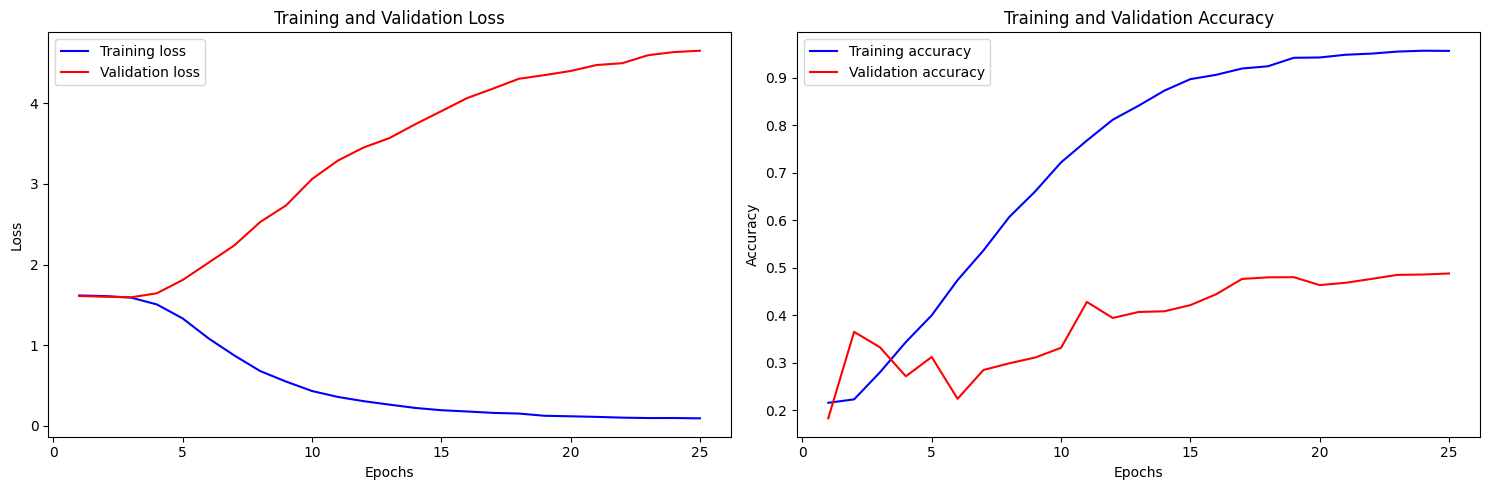

In [16]:

def plot_training_stats(stats):
    """Визуализация процесса обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    epochs = [s['epoch'] for s in stats]
    train_loss = [s['train_loss'] for s in stats]
    val_loss = [s['val_loss'] for s in stats]

    ax1.plot(epochs, train_loss, 'b-', label='Training loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy
    train_acc = [s['train_accuracy'] for s in stats]
    val_acc = [s['val_accuracy'] for s in stats]

    ax2.plot(epochs, train_acc, 'b-', label='Training accuracy')
    ax2.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_stats.png')
    plt.show()


def main():

    df = pd.read_csv('df_to_work.csv')

    print("Data sample:")
    print(df.head())
    print(f"\nTotal samples: {len(df)}")
    print(f"Number of clusters: {df['Score'].nunique()}")

    print("Initializing BERT classifier...")
    classifier = BERTClassifier(num_classes=len(df['Score'].unique()), df=df)


    print("Preparing data...")
    train_loader, val_loader = classifier.prepare_data(df)

    print("Training model...")
    training_stats = classifier.train(train_loader, val_loader, epochs=25)

    plot_training_stats(training_stats)


if __name__ == "__main__":
    main()